# Aplicação de suavização exponencial

Modelos de suavização exponenciais em séries temporais são métodos de previsão que atualizam o nível da série dando mais peso às observações recentes. A lógica é simples: valores novos carregam mais informação sobre o estado atual do processo do que valores antigos. A versão simples ajusta apenas o nível; a versão dupla incorpora tendência; e a versão tripla adiciona sazonalidade.

Comentários dos experimentos

SES (Simples): Com o $\alpha$ baixo os erros foram mais altos devido a forte suavização que levou a uma resposta lenta às mudanças.Já o $\alpha$ intermediário demonstrou uma melhora significatica, nesse caso ele encontrou equilíbrio entre suavização e resposta. O método mais radical com $\alpha=0.8$o seu desempenho é semelhante ao melhor modelo, dá maior peso às últimas observações funcionou bem para esse tipo de série. Por fim o ajuste automático, teve um performance equivalente ao $\alpha=0.8$ e vemos que o parâmetro encontrado foi muito próximo, o método encontrou um nível ótimo que favorece resposta rápida.

Holt (Dupla): Os valores de $\alpha=0.3$ e $\beta=0.1$ tiveram erros moderados, assim como vimos com a suavização simples, tais valores levaram a tendência a ser atualizada de forma lenta. Assumindo valores mais moderados, o modelo ficou mais sensível às variações, o que piorou a estabilidade e o seu desempenho. A faiza mais extrema de valores testados teve o pior resultado entre os manuais; excesso de sensibilidade introduziu ruído e distorceu a tendência. O ajuste automático foi melhor MAE e bom RMSE, o ajuste interno encontrou um equilíbrio que acompanha a tendência sem oscilar demais. Observamos que os valores obtidos resultaram em um $\alpha$ alto e um $\beta$ baixo. Nas configurações manuais, testamos valores de mesma ordem de magnitude para ambos os parâmetros e, mesmo “acertando” um deles, acabamos sendo penalizados no desempenho geral.

Holt-Winters (Tripla): Os valores modestos do teste tiveram bons resultados, sua atualização foi suave de nível, tendência e sazonalidade. Indo para a faixa seguinte de valores, houve um aumento de erro, os parâmetros médios deixaram o modelo excessivamente reativo. E quando vamos mais a extremo temos o pior desempenho, a combinação agressiva amplifica ruído na tendência e sazonalidade. Por úlitmo, o ajuste automático, foi o  melhor MAE,  RMSE um pouco maior que o melhor manual, o seu ajuste foi equilibrado para nível, tendência e sazonalidade.

Em suma, o melhor modelo ajustado foi o Holt-Winters com suavização tripla. Isso indica que os componentes de nível, tendência e sazonalidade são relevantes para explicar a dinâmica da série. O ajuste simultâneo desses três elementos reduz o erro de previsão em relação às versões simples e dupla, mostrando que a série apresenta variações sistemáticas no tempo que não podem ser capturadas apenas pelo nível ou pela tendência.

Os gráficos de ACF dos resíduos reforçam essa conclusão. No SES observa-se autocorrelação perceptível, percebemos um vai-vem em ciclos, indicando padrão não explicado pela complexidade desse modelo. Na suavização dupla o padrão diminui, mas ainda existe estrutura remanescente. Já no Holt-Winters a autocorrelação residual fica próxima de ruído branco, sugerindo que o modelo capturou adequadamente a dependência temporal e deixou poucos padrões nos resíduos.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

series = pd.read_csv('data_updated.csv')

h = 5
y = series['volume'][:-h]
real = series['volume'][-h:]


### Funções auxiliares

In [10]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))


# Suavização Exponencial Simples (SES)

α ajustado automaticamente: 0.8763233094229902


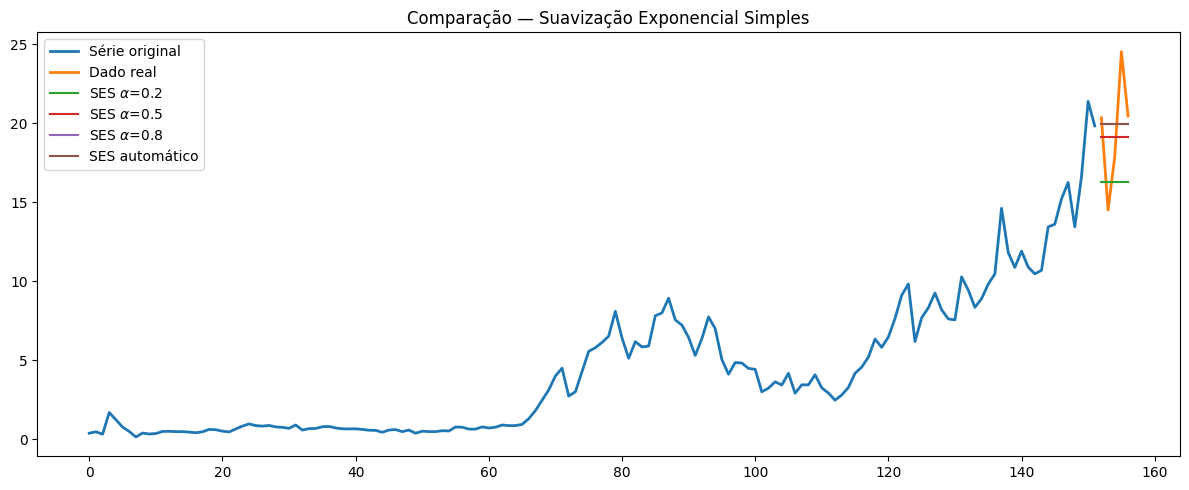


Erros — Suavização Exponencial Simples (SES)
           Modelo       MAE      RMSE
0       SES α=0.2  3.961516  4.626336
1       SES α=0.5  2.757714  3.324450
2       SES α=0.8  2.596486  3.319232
3  SES automático  2.593354  3.321068


<Figure size 1000x400 with 0 Axes>

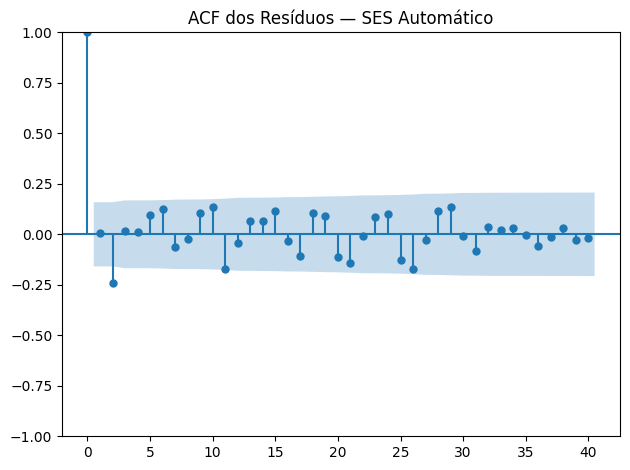

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf

# valores de alpha para teste
alphas = [0.2, 0.5, 0.8]
ses_forecasts = {}
ses_errors = []

for a in alphas:
    model = ExponentialSmoothing(y)
    fit = model.fit(smoothing_level=a, optimized=False)
    fc = fit.forecast(h)
    ses_forecasts[f"SES $\\alpha$={a}"] = fc

    ses_errors.append({
        "Modelo": f"SES α={a}",
        "MAE": mae(real, fc),
        "RMSE": rmse(real, fc)})

# automático
model_auto = ExponentialSmoothing(y)
fit_auto = model_auto.fit(optimized=True)
fc_auto = fit_auto.forecast(h)
ses_forecasts["SES automático"] = fc_auto

ses_errors.append({
    "Modelo": "SES automático",
    "MAE": mae(real, fc_auto),
    "RMSE": rmse(real, fc_auto)})

# mostra alpha escolhido automaticamente
print(f"α ajustado automaticamente: {fit_auto.params['smoothing_level']}")

# gráfico das previsões
plt.figure(figsize=(12, 5))
y.plot(label="Série original", linewidth=2)
real.plot(label="Dado real", linewidth=2)
for label, fc in ses_forecasts.items():
    fc.plot(label=label)
plt.title("Comparação — Suavização Exponencial Simples")
plt.legend()
plt.tight_layout()
plt.show()

# tabela de erros
ses_errors = pd.DataFrame(ses_errors)
print("\nErros — Suavização Exponencial Simples (SES)")
print(ses_errors)

# ACF dos resíduos do modelo automático
plt.figure(figsize=(10, 4))
plot_acf(fit_auto.resid.dropna(), lags=40)
plt.title("ACF dos Resíduos — SES Automático")
plt.tight_layout()
plt.show()


# Suavização Exponencial Dupla (Holt / Holt Linear Trend)

α ajustado automaticamente: 0.8328225690955866
α ajustado automaticamente: 0.0


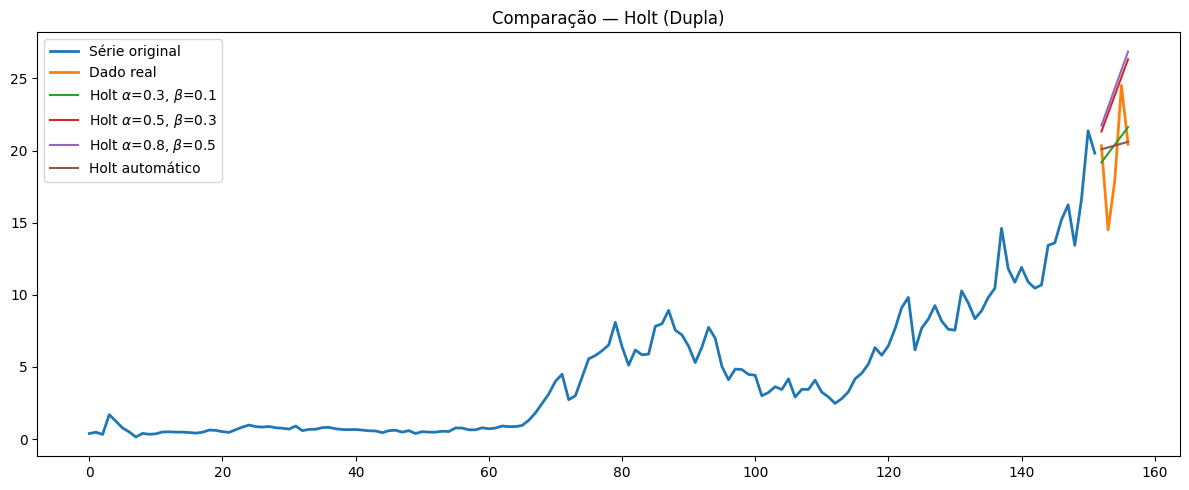


Erros — Holt (Dupla)
              Modelo       MAE      RMSE
0  Holt α=0.3, β=0.1  2.729260  3.141400
1  Holt α=0.5, β=0.3  4.289017  5.222478
2  Holt α=0.8, β=0.5  4.763078  5.620871
3    Holt automático  2.525490  3.321650


<Figure size 1000x400 with 0 Axes>

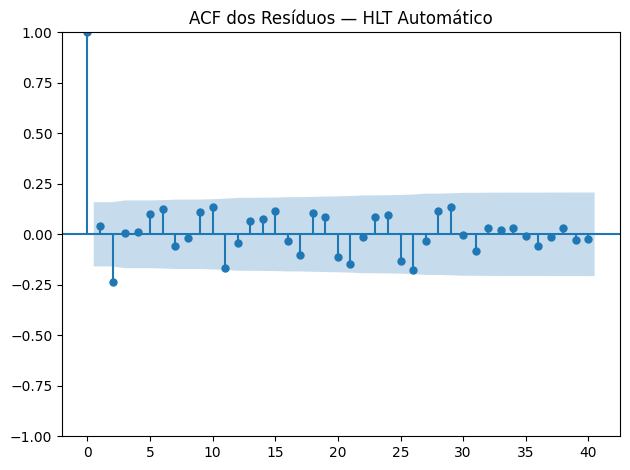

In [12]:
# valores de alpha e gamma para teste

params_holt = [
    (0.3, 0.1),
    (0.5, 0.3),
    (0.8, 0.5)
]

holt_forecasts = {}
holt_errors = []

for a, b in params_holt:
    model = ExponentialSmoothing(y, trend="add", seasonal=None)
    fit = model.fit(
        smoothing_level=a,
        smoothing_trend=b,
        optimized=False
    )
    fc = fit.forecast(h)
    holt_forecasts[f"Holt $\\alpha$={a}, $\\beta$={b}"] = fc

    holt_errors.append({
        "Modelo": f"Holt α={a}, β={b}",
        "MAE": mae(real, fc),
        "RMSE": rmse(real, fc)})

# automático
model_auto_holt = ExponentialSmoothing(y, trend="add")
fit_auto_holt = model_auto_holt.fit(optimized=True)
fc_auto = fit_auto_holt.forecast(h)
holt_forecasts["Holt automático"] = fc_auto

print(f"α ajustado automaticamente: {fit_auto_holt.params['smoothing_level']}")
print(f"α ajustado automaticamente: {fit_auto_holt.params['smoothing_trend']}")

plt.figure(figsize=(12, 5))
y.plot(label="Série original", linewidth=2)
real.plot(label="Dado real", linewidth=2)
for label, fc in holt_forecasts.items():
    fc.plot(label=label)
plt.title("Comparação — Holt (Dupla)")
plt.legend()
plt.tight_layout()
plt.show()

holt_errors.append({
    "Modelo": "Holt automático",
    "MAE": mae(real, fc_auto),
    "RMSE": rmse(real, fc_auto)})

holt_errors = pd.DataFrame(holt_errors)
print("\nErros — Holt (Dupla)")
print(holt_errors)

# ACF dos resíduos do modelo automático
plt.figure(figsize=(10, 4))
plot_acf(fit_auto_holt.resid.dropna(), lags=40)
plt.title("ACF dos Resíduos — HLT Automático")
plt.tight_layout()
plt.show()


# Suavização Exponencial Tripla (Holt-Winters)

α ajustado automaticamente: 0.9999999850988388
α ajustado automaticamente: 0.02454863856507013
α ajustado automaticamente: 6.803787564618744e-09


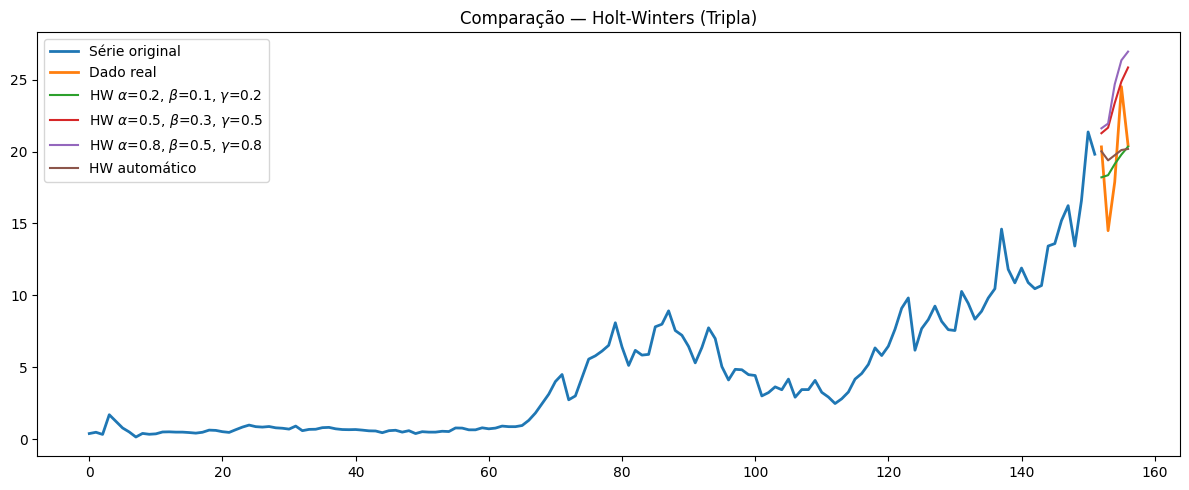


Erros — Holt-Winters (Tripla)
                   Modelo       MAE      RMSE
0  HW α=0.2, β=0.1, γ=0.2  2.408591  2.942695
1  HW α=0.5, β=0.3, γ=0.5  3.878260  4.732556
2  HW α=0.8, β=0.5, γ=0.8  4.781603  5.466004
3           HW automático  2.344490  3.065717


<Figure size 1000x400 with 0 Axes>

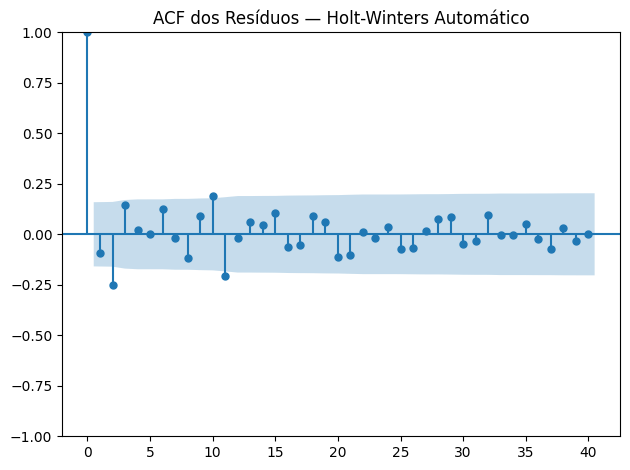

In [13]:
seasonal_periods = 52
params_hw = [
    (0.2, 0.1, 0.2),
    (0.5, 0.3, 0.5),
    (0.8, 0.5, 0.8)
]

hw_forecasts = {}
hw_errors = []

for a, b, g in params_hw:
    model = ExponentialSmoothing(
        y,
        trend="add",
        seasonal="add",
        seasonal_periods=seasonal_periods
    )
    fit = model.fit(
        smoothing_level=a,
        smoothing_trend=b,
        smoothing_seasonal=g,
        optimized=False
    )
    fc = fit.forecast(h)
    hw_forecasts[f"HW $\\alpha$={a}, $\\beta$={b}, $\\gamma$={g}"] = fc

    hw_errors.append({
        "Modelo": f"HW α={a}, β={b}, γ={g}",
        "MAE": mae(real, fc),
        "RMSE": rmse(real, fc),
        
    })

# automático
model_auto_hw = ExponentialSmoothing(
    y,
    trend="add",
    seasonal="add",
    seasonal_periods=seasonal_periods
)
fit_auto_hw = model_auto_hw.fit(optimized=True)
fc_auto = fit_auto_hw.forecast(h)
hw_forecasts["HW automático"] = fc_auto

print(f"α ajustado automaticamente: {fit_auto_hw.params['smoothing_level']}")
print(f"α ajustado automaticamente: {fit_auto_hw.params['smoothing_trend']}")
print(f"α ajustado automaticamente: {fit_auto_hw.params['smoothing_seasonal']}")

# ---- HOLT–WINTERS ----
plt.figure(figsize=(12, 5))
y.plot(label="Série original", linewidth=2)
real.plot(label="Dado real", linewidth=2)
for label, fc in hw_forecasts.items():
    fc.plot(label=label)
plt.title("Comparação — Holt-Winters (Tripla)")
plt.legend()
plt.tight_layout()
plt.show()


hw_errors.append({
    "Modelo": "HW automático",
    "MAE": mae(real, fc_auto),
    "RMSE": rmse(real, fc_auto)})

hw_errors = pd.DataFrame(hw_errors)
print("\nErros — Holt-Winters (Tripla)")
print(hw_errors)

# ACF dos resíduos do modelo automático
plt.figure(figsize=(10, 4))
plot_acf(fit_auto_hw.resid.dropna(), lags=40)
plt.title("ACF dos Resíduos — Holt-Winters Automático")
plt.tight_layout()
plt.show()